# Imports

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch 
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
# import wandb
# wandb.init(mode="disabled")

# Loading Data & The Model

In [2]:
emotions=load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_ds=emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
model_ckpt="distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model= AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded= emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


# Transformers as Feature Extractors

In [6]:
# For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. 
# Since this token appears at the start of each sequence

def extract_hidden_states(batch):
    inputs= {k:v.to(device) for k,v in batch.items() 
            if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state=model(**inputs).last_hidden_state
        
    return {'hidden_state':last_hidden_state[:,0].cpu().numpy()} #[batch_size, n_tokens, hidden_dim]

In [7]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask','label'])
emotions_hidden=emotions_encoded.map(extract_hidden_states,batched=True)
print(emotions_hidden['train'].column_names)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']


In [8]:
X_train=np.array(emotions_hidden['train']['hidden_state'])
X_valid=np.array(emotions_hidden['validation']['hidden_state'])

y_train=np.array(emotions_hidden['train']['label'])
y_valid=np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((16000, 768), (2000, 768), (16000,), (2000,))

## Visualizing the training set

In [9]:
X_scaled=MinMaxScaler().fit_transform(X_train)
mapper=UMAP(n_components=2,metric="cosine").fit(X_scaled)

In [10]:
df_emb=pd.DataFrame(mapper.embedding_, columns=['X','Y'])
df_emb['label']=y_train
df_emb.head()

,X,Y,label
0,4.289427,6.628970,0
1,-3.024840,6.100833,0
2,5.378714,3.176969,3
3,-2.255388,4.005692,2
4,-3.399514,4.128515,3


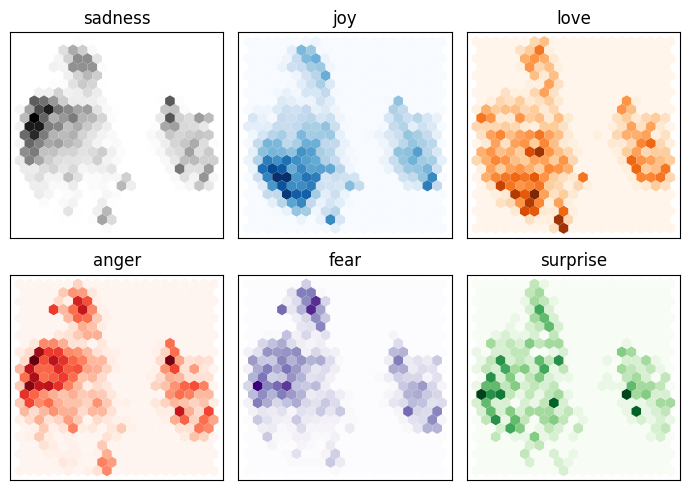

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

- the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions
- joy and love are well separated from the negative emotions and also share a similar space
- surprise is scattered all over the place

## Testing Different Models

### Will start with the dummy classifer as a baseline

In [12]:
dummy_clf=DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

### Testing with Logistic Regression & SVM

In [13]:
lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.606

In [14]:
svm_clf=SVC()
svm_clf.fit(X_train,y_train)
svm_clf.score(X_valid,y_valid)

0.583

#### Note: the goal of this exercise is to get an idea of how well normal ML models can achive with this approach
#### More hyperparameter tunning can be done and testing different models and even fixing the unbalanced labels but this isnt the goal of the exercise

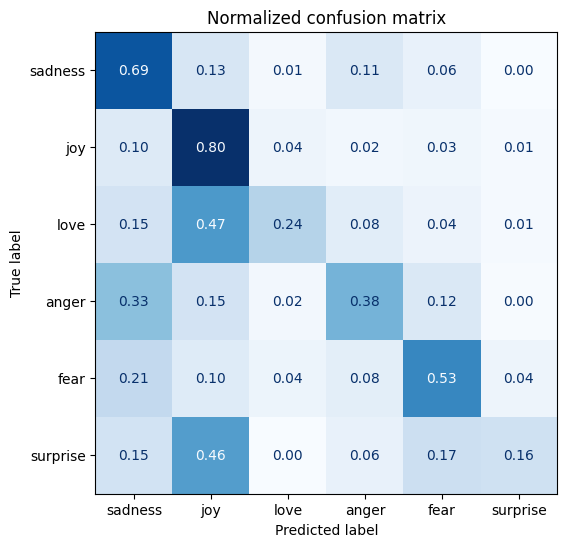

In [15]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

- anger and fear are most often confused with sadness
- love and surprise are frequently mistaken for joy

# Fine-Tuning Transformers

In [16]:
num_labels=6
model= AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    acc=accuracy_score(labels,preds)
    recall=recall_score(labels,preds,average='weighted')
    precision=precision_score(labels,preds,average='weighted')
    f1=f1_score(labels,preds,average='weighted')
    return {
        "accuracy":acc,
        "recall":recall,
        "precision":precision,
        "f1":f1
    }
    

In [18]:
batch_size=64
logging_steps=len(emotions_encoded['train'])//batch_size
model_name=f"{model_ckpt}-finetuned-emotion"
training_args=TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_steps=logging_steps,
    report_to=None
)

In [19]:
trainer=Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: pandahd75. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.803800,0.308420,0.909500,0.909500,0.909066,0.908889
2,0.251600,0.213947,0.924500,0.924500,0.924815,0.924388


TrainOutput(global_step=500, training_loss=0.5277456817626953, metrics={'train_runtime': 153.3831, 'train_samples_per_second': 208.628, 'train_steps_per_second': 3.26, 'total_flos': 720342861696000.0, 'train_loss': 0.5277456817626953, 'epoch': 2.0})

In [20]:
preds_output=trainer.predict(emotions_encoded['validation'])
preds_output.metrics

{'test_loss': 0.21394671499729156,
 'test_accuracy': 0.9245,
 'test_recall': 0.9245,
 'test_precision': 0.9248146408726244,
 'test_f1': 0.9243883696056557,
 'test_runtime': 2.3723,
 'test_samples_per_second': 843.054,
 'test_steps_per_second': 13.489}

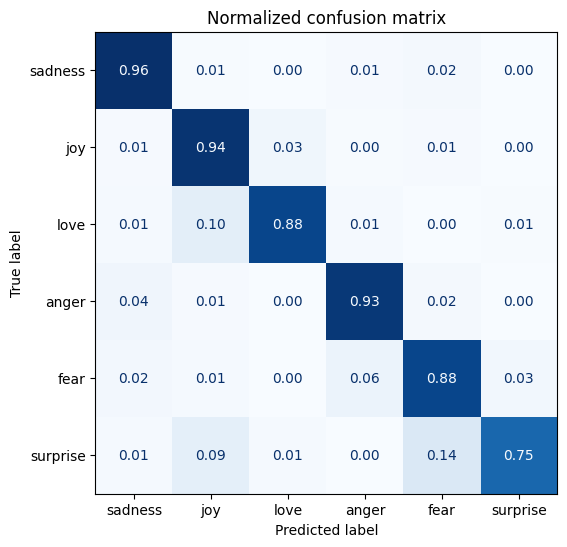

In [21]:
y_preds=np.argmax(preds_output.predictions,axis=1)
plot_confusion_matrix(y_preds,y_valid,labels)

- Love category is still often confused with joy, which seems natural. 
- Surprise is also frequently mistaken for joy, or confused with fear.